# How to describe a set of images in terms of visual clusters

This is a tutorial created by Sebastian Topalian on how to process a set of images with a pretrained computer vision model to obtain latent representations, cluster them with K-means, and calculate how many photos belong to each category. This example was adapted by the following [example](https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34) from Gabe Flomo. If you are having problems with the tutorial, or have any questions contact [@littlecodelover](https://twitter.com/littlecodelover) or [LinkedIn](https://www.linkedin.com/in/sebastian-topalian-3b1743204/).

Here we use images related to the following publication(s):
- ECO-STP Conference: Quantitative Image Analysis of Biosolids: Evaluating morphological parameters versus visual features

## Download zip file and unzip

First we download pictures from a sample of inactivated biomass. These photos were taken and segmented with an Ocelloscope and accompanying software from [ParticleTech](https://particletech.dk).

In [26]:
!git clone https://github.com/waterboy96/ImageAnalysis.git

Cloning into 'ImageAnalysis'...


In [27]:
import zipfile
with zipfile.ZipFile('ImageAnalysis/Particles.zip', 'r') as zip_ref:
    zip_ref.extractall('')

## Import necessary packages and visualize a particle

You probably will have to install some packages, such as keras and tensorflow. In that case, uncomment the cell below.

In [ ]:
#!pip install --quiet keras
#!pip install --quiet tensorflow

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow
from keras.applications import Xception
from keras.models import Model
from keras.utils import image_dataset_from_directory, load_img

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [29]:
particles = []
with os.scandir('Particles') as files:
    for file in files:
        if file.name.endswith('.png'):
            particles.append(file.name)

In [30]:
particles = sorted(['Particles/'+p for p in particles if not p.startswith('.')])

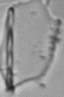

In [31]:
from IPython.display import display, Image
display(Image(particles[0], width=200))

## Load Xception model and generate feature vectors

In [5]:
model = Xception()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)



91884032/91884032 [==============================] - 3s 0us/step


In [6]:
ds = image_dataset_from_directory('Particles', batch_size= 64, image_size = (299,299), labels = None, shuffle = False, label_mode= None)
df = pd.DataFrame(model.predict(ds))

Found 1571 files belonging to 1 classes.
25/25 [==============================] - 127s 5s/step


In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.0,54.397144,31.481157,0.0,0.0,4.651548,5.417986,0.0,54.248116,0.0,...,0.0,0.547658,0.584891,0.0,0.0,0.0,0.0,0.0,28.481792,0.0
1,0.0,9.573953,68.261002,0.0,0.0,9.481183,2.677149,0.0,62.059052,0.0,...,0.0,0.000000,9.717825,0.0,0.0,0.0,0.0,0.0,32.673840,0.0
2,0.0,73.179192,54.697891,0.0,0.0,2.832886,1.836953,0.0,95.356689,0.0,...,0.0,0.000000,6.211996,0.0,0.0,0.0,0.0,0.0,36.757694,0.0
3,0.0,9.200827,47.524483,0.0,0.0,2.823268,1.756659,0.0,111.240616,0.0,...,0.0,0.083808,0.606886,0.0,0.0,0.0,0.0,0.0,49.801193,0.0
4,0.0,9.845026,14.987373,0.0,0.0,1.928168,3.383057,0.0,3.051223,0.0,...,0.0,0.094376,0.000000,0.0,0.0,0.0,0.0,0.0,18.205927,0.0


We now have a vector of length 2048 for each picture in our sample. These vectors represent the output of the penultimate layer in the Xception model which can be used to describe our images.

## Reduce dimensionality with PCA

In [8]:
df_scaled = (df-df.mean())/df.std()
df_scaled.dropna(axis = 1, inplace = True)

In [9]:
pca = PCA()
pca.fit(df_scaled)

PCA()

We pick a threshold of how much of the variance that should be retained. Here we select 99%. Reducing the dimensionality of the vectors helps with the computational time of clustering in the next step.

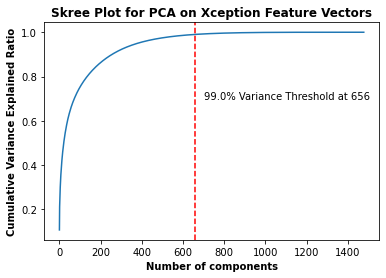

In [10]:
variance_threshold = 0.99

plt.plot([x for x in range(len(pca.explained_variance_))], np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components', fontweight = 'bold')
plt.ylabel('Cumulative Variance Explained Ratio', fontweight = 'bold')
ax = plt.gca()
plt.title('Skree Plot for PCA on Xception Feature Vectors', fontweight = 'bold')
plt.axvline(np.argmax(np.cumsum(pca.explained_variance_ratio_)>variance_threshold), linestyle = '--', c = 'red')
plt.text(700,0.7,f'{variance_threshold*100}% Variance Threshold at {np.argmax(np.cumsum(pca.explained_variance_ratio_)>variance_threshold)}')
plt.show()


An argument could be made to reduce the threshold to the point where the curve evens out for further reduction.

In [11]:
threshold = np.argmax(np.cumsum(pca.explained_variance_ratio_)>variance_threshold)

In [12]:
pca_threshold = PCA(n_components=threshold)

In [13]:
PCs = pca_threshold.fit_transform(df_scaled)

## K-means clustering and cluster counting

Here I have chosen 6 clusters just to speed up the procedure and keep it simple. In the paper we ended up with 10 and 15 clusters respectively which was determined by evaluating the number of clusters in a supervised fashion. 
Alternatively another technique such as hierarchical clustering can be used which does not require a predetermined number of clusters.

In [15]:
KM = KMeans(n_clusters=6)
KM.fit(PCs)

labels = KM.predict(PCs)

In [21]:
def count_values(X,clusters):
    return pd.DataFrame([(len(X[X == i])/len(X)) for i in range(clusters)]).T

In [22]:
count_values(labels, 6)

,0,1,2,3,4,5
0,0.159771,0.032463,0.399745,0.000637,0.222788,0.184596


We can see that the distribution between the different clusters for this sample is quite uneven.

This vector is what we in the beforementioned literature reffered to as cluster participation vectors which showed better performance for predicitng reject turbidity than both clusters built on conventional morphological parameters such as length, area etc. and also better performance than the mean of said morphological parameters.

## Visualisation of clusters

In [18]:
groups = {}

for file, cluster in zip(particles, labels):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [23]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the lits of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
        
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10, 10, index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

Clipping cluster size from 626 to 30


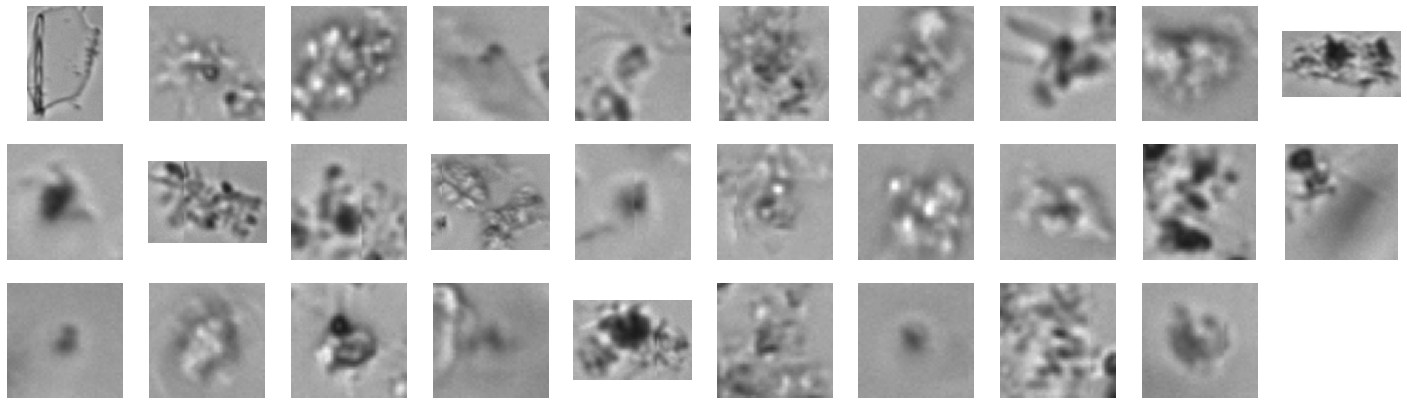

In [25]:
view_cluster(2)

**Exercise** Try changing the above number to visualize a different cluster (and don't forget cluster 0).

In [ ]:
# Your code here